In [1]:
import pandas as pd
import plotly.express as px

pd.options.mode.copy_on_write = True


In [2]:
scores = pd.read_csv(
    "sa_results.csv", index_col=0, engine="pyarrow", dtype_backend="pyarrow"
)
# df.rolling() needs the traditional datetime type
scores["Date"] = scores["Date"].astype("datetime64[ns]")
scores.sort_values(by="Date", inplace=True)
scores.dtypes


Top_Level_Folder    string[pyarrow]
Mail_Folder         string[pyarrow]
Message_File         int64[pyarrow]
From                string[pyarrow]
To                  string[pyarrow]
Cc                  string[pyarrow]
Bcc                 string[pyarrow]
Date                 datetime64[ns]
joy                 double[pyarrow]
anger               double[pyarrow]
sadness             double[pyarrow]
fear                double[pyarrow]
love                double[pyarrow]
surprise            double[pyarrow]
neg                 double[pyarrow]
neu                 double[pyarrow]
pos                 double[pyarrow]
compound            double[pyarrow]
dtype: object

In [3]:
scores


,Top_Level_Folder,Mail_Folder,Message_File,From,To,Cc,Bcc,Date,joy,anger,sadness,fear,love,surprise,neg,neu,pos,compound
,,,,,,,,,,,,,,,,,,
482568,taylor-m,sent,1,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:43:00,0.870809,0.066835,0.016119,0.040838,0.003810,0.001589,0.000,0.936,0.064,0.2144
471425,taylor-m,all_documents,1,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:43:00,0.870809,0.066835,0.016119,0.040838,0.003810,0.001589,0.000,0.936,0.064,0.2144
472533,taylor-m,all_documents,2,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:56:00,0.955962,0.021567,0.004886,0.013542,0.002495,0.001548,0.000,0.782,0.218,0.6908
483227,taylor-m,sent,2,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:56:00,0.955962,0.021567,0.004886,0.013542,0.002495,0.001548,0.000,0.782,0.218,0.6908
483338,taylor-m,sent,3,['mark.taylor@enron.com'],['shari.stack@enron.com'],[],[],1998-10-30 15:02:00,0.517597,0.115636,0.010137,0.269055,0.002557,0.085018,0.013,0.886,0.101,0.9954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113181,fischer-m,discussion_threads,339,['denise.williams@enron.com'],['ge_benefits@enron.com'],[],[],2002-07-12 11:13:00,0.995261,0.001834,0.001099,0.000816,0.000776,0.000213,0.019,0.822,0.160,0.8446
113430,fischer-m,notes_inbox,2,['denise.williams@enron.com'],['ge_benefits@enron.com'],[],[],2002-07-12 11:13:00,0.995261,0.001834,0.001099,0.000816,0.000776,0.000213,0.019,0.822,0.160,0.8446
112728,fischer-m,all_documents,428,['denise.williams@enron.com'],['ge_benefits@enron.com'],[],[],2002-07-12 11:13:00,0.995261,0.001834,0.001099,0.000816,0.000776,0.000213,0.019,0.822,0.160,0.8446


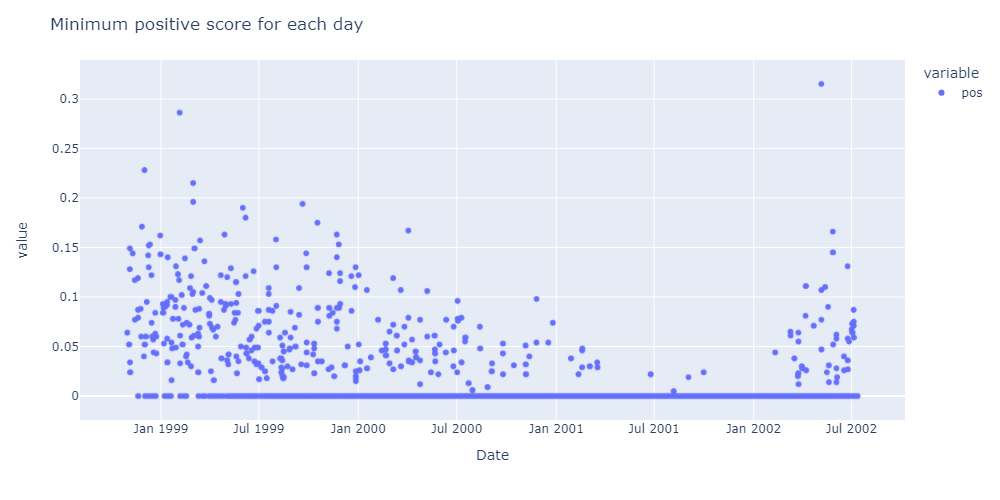

In [4]:
px.scatter(
    data_frame=scores[["Date", "pos"]]
    .rolling("1D", on="Date")
    .min(),
    x="Date",
    y=["pos"],
).update_layout(
    width=1000, height=500, title="Minimum positive score for each day"
).show(
    "png"
)


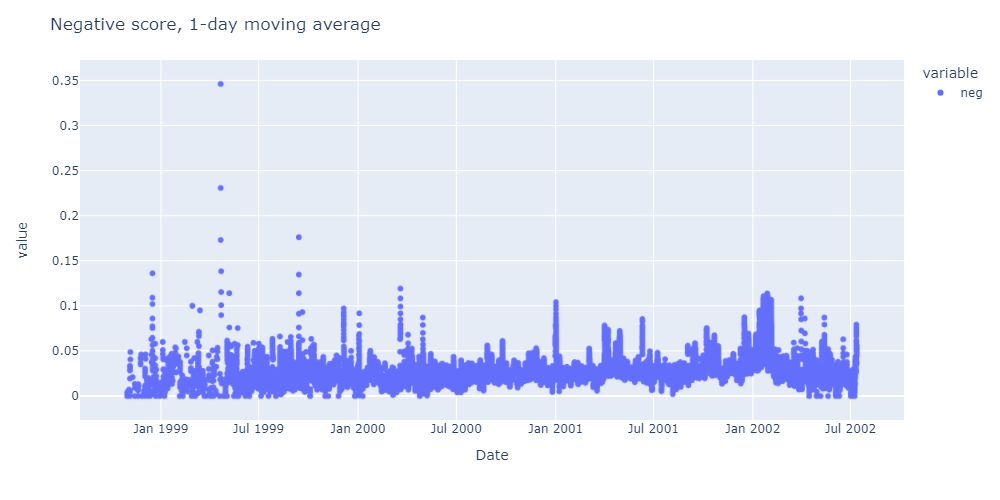

In [5]:
px.scatter(
    data_frame=scores[["Date", "neg"]]
    .rolling("1D", on="Date")
    .mean(),
    x="Date",
    y=["neg"],
).update_layout(
    width=1000, height=500, title="Negative score, 1-day moving average"
).show(
    "png"
)


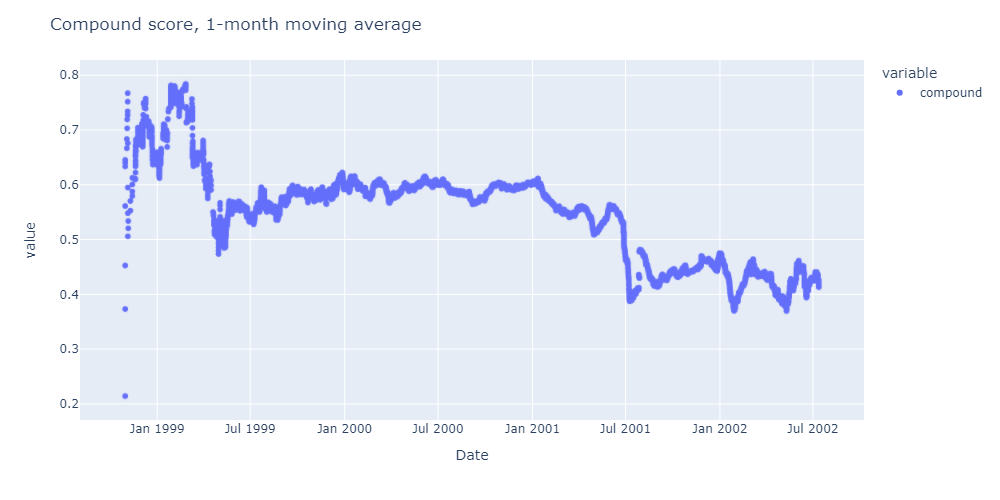

In [6]:
px.scatter(
    data_frame=scores[["Date", "compound"]]
    .rolling("30D", on="Date")
    .mean(),
    x="Date",
    y=["compound"],
).update_layout(
    width=1000, height=500, title="Compound score, 1-month moving average"
).show(
    "png"
)
